Cell 1: Imports and Device Setup
Notes:

Import essential Python libraries for data processing, computer vision, deep learning, and visualization.

Import segmentation_models_pytorch (SMP) for easy model building.

Detect if a GPU is available and set the device accordingly for faster training.

Print the device being used to confirm hardware acceleration.

In [47]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

# Install segmentation_models_pytorch if not installed
# !pip install segmentation_models_pytorch

import segmentation_models_pytorch as smp

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Cell 2: Custom Dataset Class Definition
Notes:

Define a PyTorch Dataset class to load and serve images and masks from disk.

Reads grayscale fetal ultrasound images and corresponding binary masks.

Applies optional data augmentations and preprocessing using Albumentations.

Converts images and masks to PyTorch tensors with channel dimension for model compatibility.

In [35]:
class FetalHeadDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_files=None, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        if image_files is None:
            self.image_files = sorted(os.listdir(images_dir))
        else:
            self.image_files = image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.image_files[idx])

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask = (cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.tensor(image).unsqueeze(0)  # Add channel dim to image
            mask = torch.tensor(mask).unsqueeze(0)    # Add channel dim to mask

        # If Albumentations returns mask without channel dim, add it here
        if len(mask.shape) == 2:
            mask = mask.unsqueeze(0)

        return image, mask


Cell 3: Data Augmentation and Normalization Transforms
Notes:

Define augmentation pipeline for training data to improve model robustness by introducing variations.

Includes random horizontal flips, rotations, brightness/contrast adjustments.

Normalize grayscale images with mean and std of 0.5 for single channel data.

Transform validation data only with normalization to evaluate real performance.

Convert images and masks to tensor format required by PyTorch.

In [36]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=1.0),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=1.0),
    ToTensorV2()
])


Cell 4: Dataset Splitting and DataLoader Preparation
Notes:

List all image filenames and split them into training and validation sets (80/20 split).

Instantiate datasets for training and validation with corresponding file subsets and transforms.

Create DataLoader objects to efficiently batch, shuffle (training only), and parallel load data during model training.

Print counts of training and validation samples for verification.

In [37]:
images_dir = 'data/preprocessed/train/images'
masks_dir = 'data/preprocessed/train/masks'

all_files = sorted(os.listdir(images_dir))
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

train_dataset = FetalHeadDataset(images_dir, masks_dir, image_files=train_files, transform=train_transform)
val_dataset = FetalHeadDataset(images_dir, masks_dir, image_files=val_files, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)


print(f"Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")


Training samples: 799 | Validation samples: 200


Cell 5: Model, Loss Function, and Optimizer Setup
Notes:

Instantiate a U-Net segmentation model with ResNet34 backbone pretrained on ImageNet.

Move model to GPU if available for faster computation.

Define combined Dice Loss and Binary Cross Entropy with Logits loss for effective segmentation training.

Set Adam optimizer with learning rate 1e-4 for parameter updates during training.

In [38]:
model = smp.Unet('resnet34', encoder_weights='imagenet', in_channels=1, classes=1)
model.to(device)

dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
bce_loss = torch.nn.BCEWithLogitsLoss()

def loss_fn(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Cell 6: Training and Validation Loop Functions
Notes:

train_one_epoch function: runs one full epoch of training over batches, performing forward pass, loss computation, backpropagation, and optimizer step.

validate function: evaluates model performance on validation set without updating weights.

Both return average loss for monitoring training progress and potential overfitting.

In [39]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

def validate(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


Cell 7: Model Training Loop
Notes:

Loop over defined number of epochs (10).

For each epoch, run training and validation functions.

Print the training and validation losses after each epoch to monitor learning progress and detect overfitting.



In [40]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss = validate(model, val_loader, loss_fn, device)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")


100%|████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Epoch [1/10] Train Loss: 1.4700 Val Loss: 1.3230


100%|████████████████████████████████████| 100/100 [00:23<00:00,  4.24it/s]


Epoch [2/10] Train Loss: 1.2408 Val Loss: 1.1867


100%|████████████████████████████████████| 100/100 [00:23<00:00,  4.24it/s]


Epoch [3/10] Train Loss: 1.1551 Val Loss: 1.1148


100%|████████████████████████████████████| 100/100 [00:22<00:00,  4.36it/s]


Epoch [4/10] Train Loss: 1.0903 Val Loss: 1.0620


100%|████████████████████████████████████| 100/100 [00:22<00:00,  4.36it/s]


Epoch [5/10] Train Loss: 1.0437 Val Loss: 1.0236


100%|████████████████████████████████████| 100/100 [00:23<00:00,  4.35it/s]


Epoch [6/10] Train Loss: 1.0041 Val Loss: 0.9862


100%|████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch [7/10] Train Loss: 0.9661 Val Loss: 0.9467


100%|████████████████████████████████████| 100/100 [00:23<00:00,  4.35it/s]


Epoch [8/10] Train Loss: 0.9317 Val Loss: 0.9254


100%|████████████████████████████████████| 100/100 [00:23<00:00,  4.28it/s]


Epoch [9/10] Train Loss: 0.9046 Val Loss: 0.8977


100%|████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


Epoch [10/10] Train Loss: 0.8737 Val Loss: 0.8715


Cell 8: Visualizing Model Predictions
Notes:

Switch model to evaluation mode.

Run inference on a few validation images.

Apply sigmoid to model outputs to convert logits to probabilities.

Visualize original input images, ground truth masks, and predicted masks side-by-side.

Helps qualitatively assess segmentation performance.

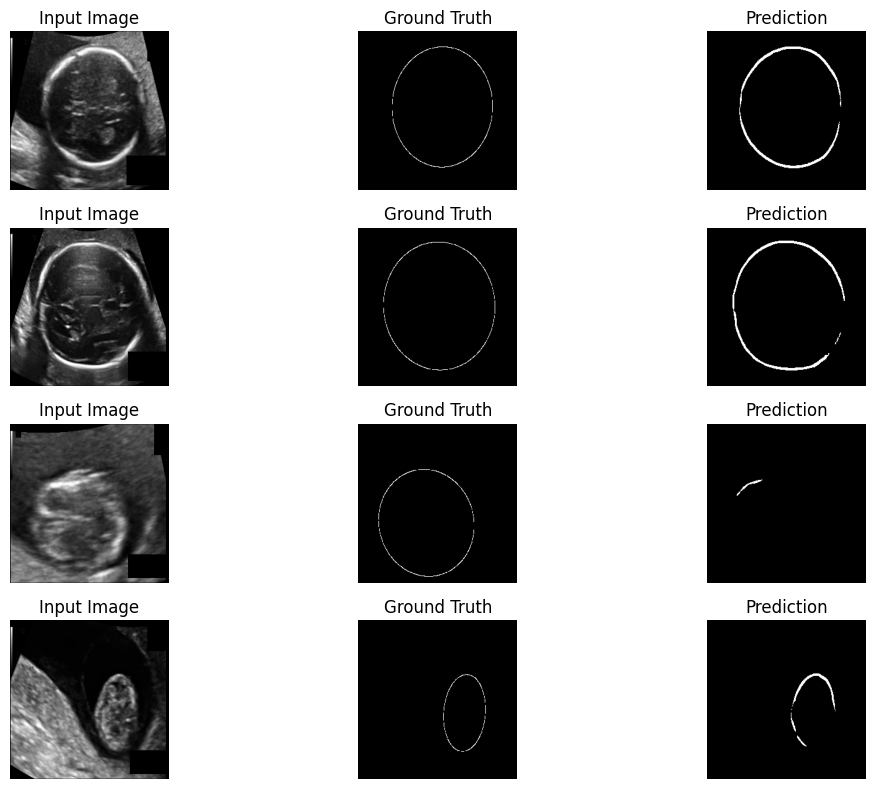

In [41]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs).cpu().numpy()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))
    for i in range(4):
        plt.subplot(4, 3, 3*i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(4, 3, 3*i + 2)
        plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(4, 3, 3*i + 3)
        plt.imshow(preds[i, 0] > 0.5, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Dice Coefficient and IoU Metric Calculation
Define two functions dice_coeff and iou_score to compute standard segmentation evaluation metrics.

Both apply a threshold of 0.5 on model output probabilities to get binary predictions.

Dice coefficient measures overlap between predicted and true masks, emphasizing agreement.

Intersection over Union (IoU) measures the ratio of intersection to union of predicted and true masks.

Run the model in evaluation mode without gradient computation for efficiency.

Loop through validation dataset to accumulate metric scores.

Compute and print the average Dice and IoU scores over the entire validation set to quantitatively assess model segmentation performance.

In [42]:
def dice_coeff(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2 * intersection + eps) / (union + eps)
    return dice.item()

def iou_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.item()

model.eval()
dice_scores = []
iou_scores = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        dice_scores.append(dice_coeff(preds, masks))
        iou_scores.append(iou_score(preds, masks))

print(f"Validation Dice Coefficient: {sum(dice_scores) / len(dice_scores):.4f}")
print(f"Validation IoU Score: {sum(iou_scores) / len(iou_scores):.4f}")


Validation Dice Coefficient: 0.2549
Validation IoU Score: 0.1462


Saving Model Checkpoints
Notes (to insert near saving code):

Create checkpoints folder if not existing.

Save trained model weights to disk for future loading, inference, or fine-tuning.

Enables resuming training or deploying the model without retraining.

In [44]:
import os

os.makedirs("checkpoints", exist_ok=True)

In [45]:
torch.save(model.state_dict(), "checkpoints/baseline_unet.pth")
